In [14]:
# Import necessary libraries and configure matplotlib parameters
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import pandas as pd 
import numpy as np
import seaborn as sns
import math
import time
import tqdm
import gc
from numba import jit, prange
from joblib import Parallel, delayed
from scipy import stats
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MultipleLocator
from brokenaxes import brokenaxes
from pathlib import Path

mpl.rcdefaults()
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 2.8
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.xmargin'] = 0.05
plt.rcParams['axes.grid']='True'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['ytick.right'] = 'True'
plt.rcParams['xtick.minor.visible'] ='True'
plt.rcParams['ytick.minor.visible'] ='True'
plt.rcParams['xtick.major.size'] =10
plt.rcParams['xtick.minor.size'] =5
plt.rcParams['xtick.major.width'] =2
plt.rcParams['xtick.minor.width'] =1
plt.rcParams['xtick.major.pad']=8
plt.rcParams['ytick.major.size'] =10
plt.rcParams['ytick.minor.size'] =5
plt.rcParams['ytick.major.width'] =2
plt.rcParams['ytick.minor.width'] =1
plt.rcParams['ytick.major.pad']=8
plt.rcParams['figure.subplot.wspace']=0.25
plt.rcParams['figure.subplot.hspace']=0.5
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['grid.linewidth'] = 2
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.8
plt.rcParams['savefig.bbox']='tight'
plt.rcParams['savefig.format']='pdf'
rc_dict = mpl.rcParams.copy()

In [16]:
# Generate simulated Burst sequences
def generate_phase_centers(m, max_wid, min_gap, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    if (m - 1) * min_gap > max_wid:
        raise ValueError("Cannot generate a valid sequence because (m-1)*min_gap > 1")
    remaining_space = max_wid - (m - 1) * min_gap
    random_points = np.random.uniform(low=0, high=1, size=m + 1)
    total = np.sum(random_points)
    normalized_gaps = random_points / total * remaining_space
    cluster_centers = []
    current = normalized_gaps[0]
    cluster_centers.append(current)
    for i in range(1, m):
        current += min_gap + normalized_gaps[i]
        cluster_centers.append(current)
    return cluster_centers

def distribute_multinomial(n, m, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    remaining_apples = n - m
    if remaining_apples == 0:
        return [1] * m
    allocations = np.random.multinomial(remaining_apples, [1/m]*m)
    allocations = allocations + 1
    return allocations.tolist()

def generate_clustered_phases(n, m, max_wid, min_gap, sigma, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    cluster_centers = generate_phase_centers(m,max_wid, min_gap, random_seed)
    points_in_cluster=distribute_multinomial(n, m, random_seed)
    phases_sim=[]
    for center, count in zip(cluster_centers, points_in_cluster):
        generated_points = stats.norm.rvs(loc=center, scale=sigma, size=int(count))
        generated_points = generated_points % 1.0
        phases_sim.extend(generated_points)
    phases_sim = np.array(phases_sim)
    np.random.shuffle(phases_sim)
    return phases_sim, points_in_cluster, cluster_centers

# def plot_clusters(phases_sim, points_in_cluster,cluster_centers, sigma, bins=50):
#     plt.figure(figsize=(12, 6))
#     bin_edges = np.linspace(0, 1, bins + 1)
#     bin_width = bin_edges[1] - bin_edges[0]
#     plt.hist(phases_sim, bins=bin_edges,alpha=0.6, color='skyblue', edgecolor='black')
#     x = np.linspace(0, 1, 1000)
#     for center, count in zip(cluster_centers, points_in_cluster):
#         density = stats.norm.pdf(x, loc=center, scale=sigma) * count * bin_width
#         if center < 3 * sigma:
#             density += stats.norm.pdf(x, loc=center+1, scale=sigma) * count * bin_width
#         if center > 1 - 3 * sigma:
#             density += stats.norm.pdf(x, loc=center-1, scale=sigma) * count * bin_width
#         plt.plot(x, density, 'r--', linewidth=1)
#         plt.axvline(center, color='red', linestyle='--', linewidth=1)
#     plt.xlabel('Phase')
#     plt.ylabel('Count')
#     plt.grid(True)

def generate_burst_sequences(period_og, t_obs, n, m, max_wid, min_gap, sigma, random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)
    phases_sim, points_in_cluster, cluster_centers = generate_clustered_phases(n, m, max_wid, min_gap, sigma, random_seed)
    start_s_i = phases_sim * period_og
    bursts_i = start_s_i + np.random.rand(len(phases_sim)) * t_obs
    adjusted_bursts_i = start_s_i + np.round((bursts_i - start_s_i) / period_og) * period_og
    bursts_sim = np.sort(np.array(adjusted_bursts_i))
    return bursts_sim,phases_sim

Text(0.5, 0, 'Phase of Simulated TOA')

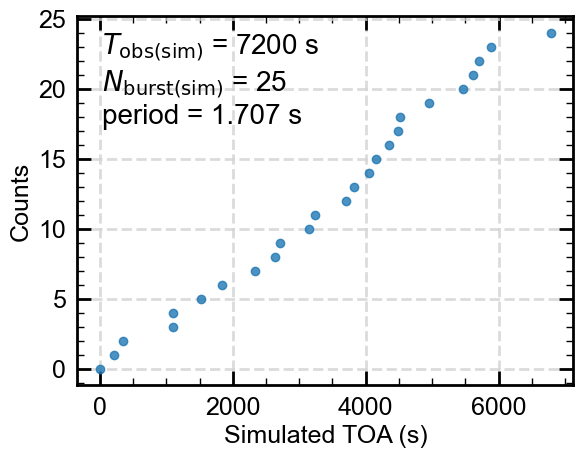

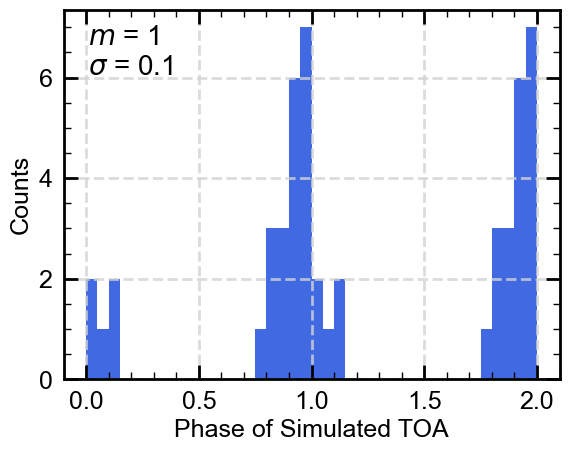

In [34]:
# Example 
period_og = 1.707 # set period (s)
t_obs = 7200 # T_obs (s)
n = 25  # N_burst
m = 1 # Emission sites
max_wid = 1 # max window width
min_gap = 0.01  # min gap
sigma = 0.1  # Gaussian standard deviation


bursts_sim, phases_sim = generate_burst_sequences(period_og, t_obs, n, m, max_wid, min_gap, sigma)
bursts_sim_0s=(bursts_sim-bursts_sim[0])

fig, ax=plt.subplots(1,1)
plt.plot(bursts_sim_0s,range(len(bursts_sim_0s)),'o',alpha=0.8)
plt.xlabel('Simulated TOA (s)')
plt.ylabel('Counts')
plt.text(0.05, 0.96, 
         '$T_{\\mathrm{obs(sim)}}$ = %i s\n$N_{\\mathrm{burst(sim)}}$ = %i\nperiod = %.3f s' % (t_obs,n,period_og), 
         transform=ax.transAxes, fontsize=20,
         verticalalignment='top', horizontalalignment='left')


folded_phases = np.fmod(bursts_sim_0s/period_og,1.0)
fig, ax=plt.subplots(1,1)
plt.hist(folded_phases, np.linspace(0,1,21), weights=None, color='royalblue',alpha=1)
plt.hist(folded_phases+1, np.linspace(1,2,21), weights=None,color='royalblue',alpha=1)
plt.text(0.05, 0.96, 
         '$m$ = %i\n$\\sigma$ = %.1f' % (m,sigma), 
         transform=ax.transAxes, fontsize=20,
         verticalalignment='top', horizontalalignment='left')
plt.ylabel('Counts')
plt.xlabel('Phase of Simulated TOA')

In [36]:
@jit(parallel=True)
def compute_chi2_numba_1D(samples, period, nbins):
    N = len(samples)
    expected_count = N / nbins 
    count_bins = np.zeros(nbins, dtype=np.int32)
    cumulative = 0.0
    factor = 1.0 + (nbins * nbins - 1) / (6.0 * N * (nbins - 1))
    for n in range(N):
        cumulative = samples[n]
        phase = (cumulative % period) / period
        bin_val = phase * nbins
        bin_idx = int(bin_val)
        if bin_idx >= nbins:
            bin_idx = nbins - 1
        count_bins[bin_idx] += 1
    chi2_stat = 0.0
    for bin in range(nbins):
        diff = count_bins[bin] - expected_count
        chi2_stat += (diff * diff) / expected_count
    chi2_stat /= (nbins - 1) 
    chi2_stat /= factor
    return chi2_stat

n_values = [100,90,80,70,60,50,40,30,20,10]
m_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

chi2_matrix = np.zeros((len(n_values), len(m_values)))
for i, n in enumerate(n_values):
    for j, m in enumerate(m_values):
        chi2_array = []
        for _ in range(100):
            bursts_sim_0s,_ = generate_burst_sequences(1.707, 7200, n, m, max_wid=1, min_gap=0.01, sigma=0.1)
            y = compute_chi2_numba_1D(bursts_sim_0s, 1.707, 30)
            chi2_array.append(y)
        chi2_avg = np.mean(chi2_array)  
        chi2_matrix[i, j] = chi2_avg  
